# Galaxy Classification and galaxy merger fraction estimates using Keras Convolutional Neural Networks

## Abstract
The [Galaxy Zoo 2](https://arxiv.org/abs/1308.3496) (GZ2) Project is the largest crowd-sourced galactic classification survey to date. It contains over 280,000 treated, and reliably labeled, images of galaxies collected from the [Sloan Digital Sky Survey](https://arxiv.org/abs/astro-ph/0006396). The results of GZ2 serve as a powerful resource and dataset, allowing for an analysis of galactic attribute distributions on large-scales, such as merger fractions. Convolutional Neural Networks (CNN) have gained increasing popularity in recent years due to their capabiliities to classify large amounts of data reliably. Lotz et al. (2008), cites a merger fraction rate of 0.45 $\pm$ 0.15 per Gyr for galaxies at z $\approx$ 0. Using a CNN, we found a merger fraction of $\approx$ 0.0008752 Gyr$^{-1}$ for galaxies at z $\approx$ 0. Our final network contained 12 total layers (2 convolutional) and reached a validation loss of 0.0199. Also presented are preliminary results using a 50-layer Residual Neural Network ([ResNets](https://arxiv.org/abs/1512.03385)). 

In [2]:
#preamble
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import pdb
import pandas as pd
import seaborn as sns
import datetime, os
import warnings

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.models import load_model
from keras.utils.generic_utils import get_custom_objects

from tensorflow.keras import backend as K

import Lab3CR as lab3


sns.set_context("paper",font_scale=1.25)
%matplotlib inline

# 1) Introduction and GZ2 

The results of GZ2 will serve as the primary dataset for our neural network. Due to the large size of the total collection of labeled images (280,00+), we select a subset of ~60,000 images to train our network on. It is worth noting that the images have undergone rigorous data validation and debiasing described in Lotz et al. and can thus be treated as a clean dataset of good quality. 

First we import our training data. 

In [3]:
data = pd.read_csv("training_classifications.csv", index_col = 0, dtype= str, skiprows = 1, names = ("smooth", "features/disk", "star/artifact", "edgeon_y", "edgeon_n", "bar_y", "bar_n", "spiral_y", "spiral_n", "bulge_none", "bulge_slight", "bulge_obvious", "bulge_dominant","odd_y", "odd_n","round_full", "round_inbetween", "round_cigar","feature_ring", "feature_lens/arc", "feature_disturbed", "feature_irregular", "feature_other", "feature_merger", "feature_dustlane","bulge_rounded", "bulge_boxy", "bulge_n","winding_tight", "winding_medium", "winding_loose","arms_1", "arms_2", "arms_3", "arms_4", "arms_more", "arms_unsure"))
data[data.columns[0:37]] = data[data.columns[0:37]].astype(float) #changing data values into floats 

## 2) Data 
Our dataset contains the vote fractions (i.e. percentage classifications) for every galaxy for each class. Given the sequential nature of the classication process of GZ2 galaxies, many galaxies have percentage fractions that are interdependent on each other. For example, if a galaxy is classified as beloning to the "smooth" class, then it is necessarily not belonging to the "features/disk" class. Thus some classes maintain a high correlation with others due to the exculsory nature of some categorizations in a question. 

Figure 1 (below) shows the correlation between labels. High correlation values are mostly found where expected. 
<img src = "correlation.jpg" width = 500>


Figure 2 (below) shows the prototypical galaxy for each class label. In total, there are 37 unique classifications a galaxy can have. The result of our inspection provides a visual confirmation of the dataset's validity, and serves as a good sanity check.
<img src="Prototype_galaxies" width = 900>

In addition to this, we generate a separate dataset from GZ2 which we can test our future model on. 

# 3) Neural Networks

## 3.1) Convolutional Neural Networks

Convolutional neural networks are the network of choice for image classificattion. Unlike other types of network, convolution allows spatial information to be preserved, allowing for greater accuracy for data which contain important features such as boundaries, shapes, or edges. The original dataset contained images of 428x428 pixels. Due to the large cost of running CNNs, we manually augmented our data. This included cropping out blank space surrounding the galaxies and resizing them (final size of 64x64 pixels).

We begin by cutting our data into our training set and validation set. We employ a standard 80-20 cut. 

In [4]:
training_data = data.sample(frac = 0.8) #80%
cv_data = data.drop(training_data.index) #20%

The nework was built in Python utilizing the `Keras` API from the `TensorFlow` package. Our network contained 10 hidden layers, some of which were convolutional. Given the computational restrictions (4GB of memory + overhead) available for this network, our network architecture was designed to ensure that runtime was prioritized while ensuring that our network could produce reliable and consistent results. We used a RMSE metric and ran the network on our dataset for 40 epochs to ensure convergence. In addtion to this, learning rates were reduced when the network began to plateau. A summary of the network is shown below. 

In [5]:
cnn_model = lab3.model
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 29, 29, 64)        0

# 4) Analysis

We measured and tracked MSE as the model evolved. The results of the training are shown in the plot below.

In [6]:
#training_2022-12-09T03:26.log
cnn_log_model = !ls -t1 nn_results/training* | head -1
cnn_model_df = pd.read_csv(cnn_log_model[0])

cnn_model_df

,epoch,accuracy,loss,lr,val_accuracy,val_loss
0,0,0.34225,0.103144,0.001,0.515357,0.061258
1,1,0.43625,0.063709,0.001,0.582143,0.039235
2,2,0.53575,0.044691,0.001,0.582143,0.029710
3,3,0.54350,0.037076,0.001,0.582143,0.026782
4,4,0.54775,0.033674,0.001,0.583571,0.024591
5,5,0.57650,0.029532,0.001,0.600714,0.023434
6,6,0.57475,0.028111,0.001,0.594643,0.023168
7,7,0.58600,0.027475,0.001,0.629286,0.021719
8,8,0.58350,0.026273,0.001,0.644286,0.020898
9,9,0.59650,0.025146,0.001,0.636071,0.020788


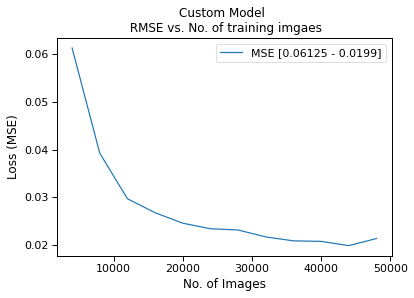

In [7]:
plt.figure()
cnn_model_imgs = 4000*np.arange(1,13) #4000 images per epoch (100 images per batch * 40 steps per epoch)

plt.plot(cnn_model_imgs, cnn_model_df['val_loss'], label = "MSE [0.06125 - 0.0199]") #MSE: [max,min]
plt.title("Custom Model \n RMSE vs. No. of training imgaes")
plt.xlabel("No. of Images")
plt.ylabel("Loss (MSE)")
plt.legend()


The network reached a minimum validation loss of 0.019900 (RMSE ~0.14). This is fairly high for a network, but there a few considerations to be made. Firstly, the galaxies from GZ2 are up to ~150 kpc away, so the images prior to augmentation can be exceptionally blurry, which may introduce error into our dataset. Our augmentation of the images often pronounces the bluriness, smoothing out features which has the effect of skewing our predictions. 

Figure 3 (below) shows the results of applying our model to our separate test dataset mentioned at the end of Section 2. The data demonstrates that there exist some intrinsic errors in our training process. For many of the detail-dependent labels, such as the number of spiral arms or bulge shape, the network predicts values much below the actual labels. This is most likely due to the augmentation and reduction of the quality of our data images. The predictions suggest that the model is struggling to differentiate between the different kinds of classes and is unable to make out differentiating characteristics. This is also why the "Odd No" classification is unusually high. The galaxies begin to look the same and thus it is difficult to tell which ones are odd. 

<table><tr>
<td> <img src="predictions/smooth_pred" width = "800" /> </td>
<td> <img src="predictions/featdisk_pred" width = "800" /> </td>
<td> <img src="predictions/starart_pred" width = "800" /> </td>
<td> <img src="predictions/edgeony_pred" width = "800"/> </td>
</tr><tr>
<td> <img src="predictions/edgeonn_pred" /> </td>
<td> <img src="predictions/bary_pred" /> </td>
<td> <img src="predictions/barn_pred" /> </td>
<td> <img src="predictions/spiraly_pred" /> </td>
</tr><tr>
<td> <img src="predictions/spiraln_pred"/> </td>
<td> <img src="predictions/bulgenone_pred"  /> </td>
<td> <img src="predictions/bulgeslight_pred" /> </td>
<td> <img src="predictions/bulgeobv_pred" /> </td>
</tr><tr>
<td> <img src="predictions/bulgedom_pred"  /> </td>
<td> <img src="predictions/oddy_pred" /> </td>
<td> <img src="predictions/oddn_pred" /> </td>
<td> <img src="predictions/roundfull_pred"  /> </td>
</tr><tr>
<td> <img src="predictions/roundibtn_pred"  /> </td>
<td> <img src="predictions/roundcigar_pred" /> </td>
<td> <img src="predictions/featring_pred" /> </td>
<td> <img src="predictions/featlensarc_pred" /> </td>
</tr><tr>
<td> <img src="predictions/featdist_pred" /> </td>
<td> <img src="predictions/featirregular_pred" /> </td>
<td> <img src="predictions/featother_pred" /> </td>
<td> <img src="predictions/featmerger_pred" /> </td>
</tr><tr>
<td> <img src="predictions/featdustlane_pred" /> </td>
<td> <img src="predictions/bulgerounded_pred" /> </td>
<td> <img src="predictions/bulgeboxy_pred" /> </td>
<td> <img src="predictions/bulgen_pred" /> </td>
</tr><tr>
<td> <img src="predictions/windingtight_pred" /> </td>
<td> <img src="predictions/windingmed_pred" /> </td>
<td> <img src="predictions/windingloose_pred" /> </td>
<td> <img src="predictions/arms1_pred" /> </td>
</tr><tr>
<td> <img src="predictions/arms2_pred" /> </td>
<td> <img src="predictions/arms3_pred" /> </td>
<td> <img src="predictions/arms4_pred" /> </td>
<td> <img src="predictions/armsmore_pred" /> </td>
</tr><tr>   
<td> <img src="predictions/armsidk_pred" width = "800"/> </td>
</tr></table>


Aside from the mergers class, nearly every label suffers from a clustering of prediction values around a median value. That is to say that as the values of the labels change with the data, the network doesn't respond to those changes. This could be possibly due to the architecture of the network causing it to hover around the mean of the label. But the more likely explanation is for the same reasons aforementioned. Because the characteristics are smoothed out, there is very little variation seen by the network between extremes of a label. Thus, the model is tolerant and resistant to individual differences amongst galaxies of completely different classes

The merger class being an outlier to this trend suggests that there is, however, enough detail for the network to make out some differences. However, upon inspection of the galaxies for which the model predicts a 0.2 or greater label value for the merger class, it was revealed that ~40% of the galaxies weren't true mergers. Many of the galaxy images had projected stellar objects or a projected non-interacting galaxy near or along the sightline of the main galaxy. There were also a few which had lens artifacts. This again points to the same error. Galaxies with artifacts or close companions were treated similar to those with galactic pairs because, when smoothed, differences became much less detectable. 

Aside from this intrinsic error, the limitations on our computational resources made it difficult to train our network for longer, as continued training often increased the amount of data stored, clogging memory-- a problem which upsizing the images would only exacerbate. Lastly, for this network, interdependencies between classes were not considered, which undoubtedly added to the inaccuracy of this model

# 5) ResNets

Residual networks are one of the most popular architectures for classification. These types of networks mitigate one of the most prominent drawbacks of simply increading the number of layers to a network in order to improve accuracy: training error. Unlike standard neural networks, residual networks include residual layers-- from which they derive their namesake-- which allows for a stronger and often faster convergence to the mapping of the dataset onto the layers of the neural network. 

When a network begins training, it isn't always clear how the dataset is meant to map onto the layers and much of the training is spent finding this. However, residual layers allow the inputs to "skip" some layers, thus letting them map onto layers deeper in the network architecture. In doing so, the network is able to essentially compare against itself and find the underlying mapping much quicker. The exact techniques by which the network does this are described in [Kaiming et al.](https://arxiv.org/abs/1512.03385) (2015). 

For this project, we experimented with two residual networks: an out of the box network, and a customized residual network with reweighting and stronger data augmentation. We were unable to obtain results for the later due to a [known issue](https://github.com/tensorflow/tensorflow/issues/27519) with `TensorFlow.v2` and up where "KerasTensor" objects cannot be turned into "tensors" which are compatible with any reshaping function within the package. As a result, the model cannot be compiled since this ability to change the "KerasTensor" objects' shapes is what allows for reweighting. Thus, only the former out-of-the-box ResNet can be discussed. 

## 5.1) Out-Of-The-Box ResNet50
For our work with residual nets, we used the `ResNet50` model provivded in `TensorFlow`. This model is a 50-layer convolutional model with fully connected pooling and normalization layers. See below for a summary of the model. 

In [8]:
ootb_resnet = lab3.res_model
ootb_resnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 flatten_1 (Flatten)         (None, 1000)              0         
                                                                 
 dense_2 (Dense)             (None, 37)                37037     
                                                                 
 activation_3 (Activation)   (None, 37)                0         
                                                                 
Total params: 25,673,749
Trainable params: 25,620,629
Non-trainable params: 53,120
_________________________________________________________________


In [9]:
ootb_resnet_log = !ls -t1 res_nn_results/training* | head -3
ootb_resnet_df = pd.read_csv(ootb_resnet_log[2])

ootb_resnet_df

,epoch,accuracy,loss,lr,val_accuracy,val_loss
0,0,0.598951,0.098972,0.00075,0.592,0.095946
1,1,0.600667,0.093691,0.00075,0.592,0.090727
2,2,0.589833,0.088898,0.00075,0.592,0.085953
3,3,0.589667,0.084461,0.00075,0.592,0.081577


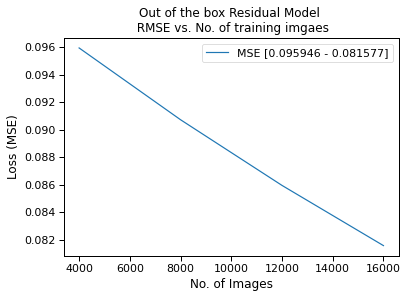

In [10]:
plt.figure()
res_n_model_imgs = 4000*np.arange(1,5)#4000 images per epoch (100 images per batch * 40 steps per epoch)
plt.plot(res_n_model_imgs, ootb_resnet_df['val_loss'], label = "MSE [0.095946 - 0.081577]") #MSE: [max,min]

plt.title("Out of the box Residual Model \n RMSE vs. No. of training imgaes")
plt.xlabel("No. of Images")
plt.ylabel("Loss (MSE)")
plt.legend()

Worth noting is that this model started at a much lower RMSE from the start as compared to the custom standard CNN developed in Section 4. In addition to this, the model also reduces RMSE almost linearly, which while slower than the CNN, has been proven to reach a much lower minimum for validation loss, as described in (Kaiming et al.)[https://arxiv.org/abs/1512.03385]. However, due to the complexity of the model and limited computational resources allocated to this project, the model was only able to train for 3 epochs before overwhelming the memory storage and failing. 

However, while the model did produce a lower RMSE than the custom CNN, by it's third epoch, the latter had a higher validation accuracy-- which in itself isn't very promising for the ResNet.

# 6) Conclusion
This project aimed to estimate the merger fraction rate for galaxies found in the GZ2 database, which were collected in the Sloan Digital Survey. The results of this work show that it is possible to train a network to predict classification probabilities for large datasets of these galaxies. While ResNets have shown promise in many other applications, due to the limited computational resources for this project, a custom convolutional neural network provided more accurate results for much less computational cost. Using this network, we predict a merger fraction rate of $\approx$ 0.0008752 Gyr$^{-1}$ for galaxies at z $\approx$ 0. While in tension with literature values, the results of the network demonstrate the power of convolutional neural networks to classify images. With more computational resources, the results of this work can only improve. 

# Bibliography
1. Jennifer M. Lotz, Patrik Jonsson, T. J. Cox, Darren Croton, Joel R. Primack, Rachel S. Somerville, and Kyle Stewart. THE MAJOR AND MINOR GALAXY MERGER RATES ATiz/i&lt 1.5. The Astrophysical Journal, 742(2):103, nov 2011. doi: 10.1088/0004-637x/742/2/103. URL https://doi.org/10.1088%2F0004-637x%2F742%2F2%2F103.


2. Kyle W. Willett, Chris J. Lintott, Steven P. Bamford, Karen L. Masters, Brooke D. Simmons, Kevin R. V. Casteels, Edward M. Edmondson, Lucy F. Fortson, Sugata Kaviraj, William C. Keel, Thomas Melvin, Robert C. Nichol, M. Jordan Raddick, Kevin Schawinski, Robert J. Simpson, Ramin A. Skibba, Arfon M. Smith, and Daniel Thomas. Galaxy zoo 2: detailed morphological classifications for 304 122 galaxies from the sloan digital sky survey. Monthly Notices of the Royal Astronomical Society, 435(4):2835–2860, sep 2013. doi: 10.1093/mnras/stt1458. URL https://doi.org/ 10.1093%2Fmnras%2Fstt1458.


3. Donald G. York, J. Adelman, Jr. John E. Anderson, Scott F. Anderson, James Annis, Neta A. Bahcall, J. A. Bakken, Robert Barkhouser, Steven Bastian, Eileen Berman, William N. Boroski, Steve Bracker, Charlie Briegel, John W. Briggs, J. Brinkmann, Robert Brunner, Scott Burles, Larry Carey, Michael A. Carr, Francisco J. Castander, Bing Chen, Patrick L. Colestock, A. J. Connolly, J. H. Crocker, Istv ́a n Csabai, Paul C. Czarapata, John Eric Davis, Mamoru Doi, Tom Dombeck, Daniel Eisenstein, Nancy Ellman, Brian R. Elms, Michael L. Evans, Xiaohui Fan, Glenn R. Federwitz, Larry Fiscelli, Scott Friedman, Joshua A. Frieman, Masataka Fukugita, Bruce Gillespie, James E. Gunn, Vijay K. Gurbani, Ernst de Haas, Merle Haldeman, Frederick H. Harris, J. Hayes, Timothy M. Heckman, G. S. Hennessy, Robert B. Hindsley, Scott Holm, Donald J. Holmgren, Chi hao Huang, Charles Hull, Don Husby, Shin-Ichi Ichikawa, Takashi Ichikawa, ˇZeljko Ivezi ́c, Stephen Kent, Rita S. J. Kim, E. Kinney, Mark Klaene, A. N. Kleinman, S. Kleinman, G. R. Knapp, John Korienek, Richard G. Kron, Peter Z. Kunszt, D. Q. Lamb, B. Lee, R. French Leger, Siriluk Limmongkol, Carl Lindenmeyer, Daniel C. Long, Craig Loomis, Jon Loveday, Rich Lucinio, Robert H. Lupton, Bryan MacKinnon, Edward J. Mannery, P. M. Mantsch, Bruce Margon, Peregrine McGehee, Timothy A. McKay, Avery Meiksin, Aronne Merelli, David G. Monet, Jeffrey A. Munn, Vijay K. Narayanan, Thomas Nash, Eric Neilsen, Rich Neswold, Heidi Jo Newberg, R. C. Nichol, Tom Nicinski, Mario Nonino, Norio Okada, Sadanori Okamura, Jeremiah P. Ostriker, Russell Owen, A. George Pauls, John Peoples, R. L. Peterson, Donald Petravick, Jeffrey R. Pier, Adrian Pope, Ruth Pordes, Angela Prosapio, Ron Rechenmacher, Thomas R. Quinn, Gordon T. Richards, Michael W. Richmond, Claudio H. Rivetta, Constance M. Rockosi, Kurt Ruthmansdorfer, Dale Sandford, David J. Schlegel, Donald P. Schneider, Maki Sekiguchi, Gary Sergey, Kazuhiro Shimasaku, Walter A. Siegmund, Stephen Smee, J. Allyn Smith, S. Snedden, R. Stone, Chris Stoughton, Michael A. Strauss, Christopher Stubbs, Mark SubbaRao, Alexander S. Szalay, Istvan Szapudi, Gyula P. Szokoly, Anirudda R. Thakar, Christy Tremonti, Douglas L. Tucker, Alan Uomoto, Dan Vanden Berk, Michael S. Vogeley, Patrick Waddell, Shu i Wang, Masaru Watanabe, David H. Weinberg, Brian Yanny, and Naoki Yasuda. The sloan digital sky survey: Technical summary. The Astronomical Journal, 120(3):1579–1587, sep 2000. doi: 10.1086/301513. URL https://doi.org/10.1086%2F301513.


4. Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. Deep residual learning forimage recognition, 2015. URL https://arxiv.org/abs/1512.03385.